In [1]:
import torch
import numpy as np

from model import FCNet
from solver import ODESolver
from plotting import plot_losses

device = torch.device('cpu')

Differential equation:

$y''(x) = - y(x)$

Initial conditions:

$y(0) = \frac{\sqrt{2}}{2}; y'(0) = \frac{\sqrt{2}}{2} $

Analytic solution:

$y(x) = \frac{\sqrt{2}}{2} \text{sin}(x) + \frac{\sqrt{2}}{2} \text{cos}(x)$

In [2]:
def rhs_function(x, y, dydx):
    return -y

def sol(x):
    return np.sqrt(2)/2*torch.sin(x) + np.sqrt(2)/2*torch.cos(x)

def d_sol_dx(x):
    return np.sqrt(2)/2*torch.cos(x) - np.sqrt(2)/2*torch.sin(x)

initial_conditions = [0.0, np.sqrt(2)/2, np.sqrt(2)/2]

Differential equation:

$y''(x) = -0.1 \text{ } y'(x) - 5 \text{ } y(x) $

Initial conditions:

$ y(0) = 1, y'(0) = 0 $

Analytic solution:

$ y(x) = e^{-\frac{x}{20}}(\frac{1}{\sqrt{399}}{\text{sin}(\frac{\sqrt{399}x}{20}}) + \text{cos}(\frac{\sqrt{399}x}{20})) $ 

In [3]:
def rhs_function(x, y, dydx):
    return -0.1 * dydx -5.0 * y

def sol(x):
    return  torch.exp(-x/20) * (1 / np.sqrt(1999) * torch.sin(np.sqrt(1999) * x / 20) + torch.cos(np.sqrt(1999) * x / 20))

def d_sol_dx(x):
    return -torch.exp(-x/20) * 100 / np.sqrt(1999) * torch.sin(np.sqrt(1999) * x / 20)

initial_conditions = [0.0, 1.0, 0.0]

Differential equation:

$y'(x) = \frac{x}{y}$

Initial conditions:

$ y(0) = 1 $

Analytic solution:

$ y(x) = ± \sqrt{x^2 + 1} $ 

In [4]:
def rhs_function(x, y):
    return x / y

def sol(x):
    return torch.sqrt(x**2 + 1)

def d_sol_dx(x):
    return x / torch.sqrt(x**2 + 1)

initial_conditions = [0.0, 1.0]

In [5]:
features_in = 1
features_out = 1
hidden = [100, 100, 100, 100, 100]

model = FCNet(features_in, hidden, features_out, activation='cas', init_weights=False).to(device)

domain = torch.linspace(-3*np.pi, 3*np.pi, steps=200).unsqueeze(1)
solution = sol(domain)
data = [domain, rhs_function, initial_conditions]

solver = ODESolver(model, data, device=device)
solver.compile('adam', lr=1e-3, loss_weights=[1.0, 1.0])
losses_domain, losses_ic = solver.train(num_epochs=10000, atol=1e-4, solution=solution, save_gif=True)
solver.create_gif(gif_save_path='gif_test4')

Training Progress:   5%|█▎                       | 509/10000 [00:05<01:43, 91.79it/s, Loss: 0.00009967 | LR: 0.00077378]


Stopping criterion met at epoch 509: Loss is less than 0.0001.
GIF saved at gif_test4/cas_100_100_100_100_100.gif


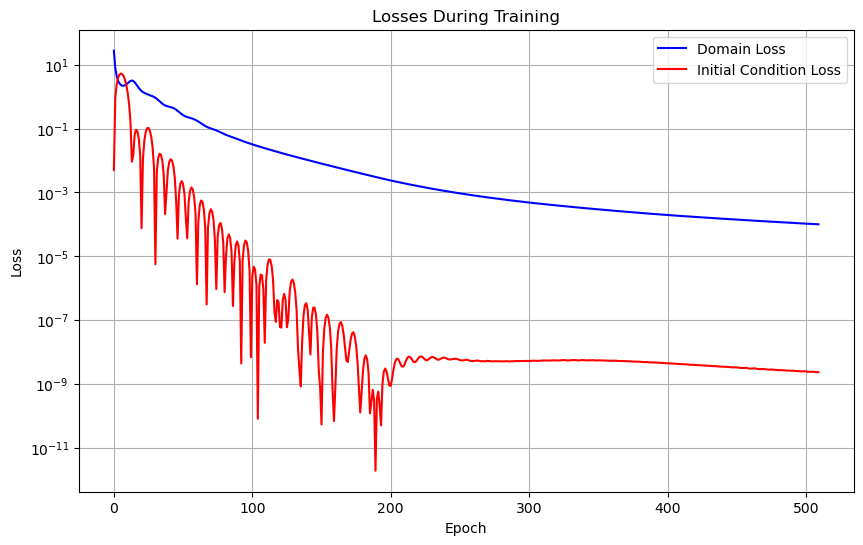

In [6]:
plot_losses(losses_domain, losses_ic)

In [7]:
model.eval()
parameter_count = sum(p.numel() for p in model.parameters())

x_point = torch.tensor([0.0], requires_grad=True).to(device)
output = model(x_point).to(device)
output.backward()

exact_value = sol(x_point).item()
exact_derivative = d_sol_dx(x_point).item()

value_error = abs(output.item() - exact_value)
derivative_error = abs(x_point.grad.item() - exact_derivative)

results = (
    f"Model parameter count: {parameter_count}\n"
    f"--- At x = {x_point.item():.4f} ---\n"
    f"Prediction: {output.item():.4f}, Exact: {exact_value:.4f}, Abs Error: {value_error:.4f}\n"
    f"Derivative: {x_point.grad.item():.4f}, Exact: {exact_derivative:.4f}, Abs Error: {derivative_error:.4f}"
)

print(results)

Model parameter count: 80301
--- At x = 0.0000 ---
Prediction: 1.0000, Exact: 1.0000, Abs Error: 0.0000
Derivative: -0.0002, Exact: 0.0000, Abs Error: 0.0002


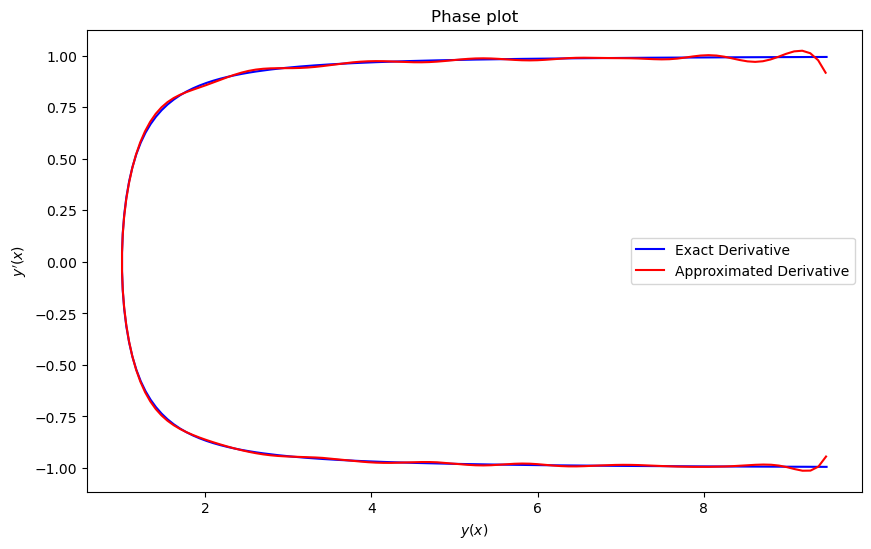

In [8]:
model.eval()

domain.requires_grad_(True)
output_model = model(domain)

derivatives_model = solver._compute_gradients(domain, output_model)

exact_y = sol(domain)
exact_dydx = d_sol_dx(domain)

domain_np = domain.detach().cpu().numpy()
output_model_np = output_model.detach().cpu().numpy()
derivatives_model_np = [grad.detach().cpu().numpy() for grad in derivatives_model]
exact_y_np = exact_y.detach().cpu().numpy()
exact_dydx_np = exact_dydx.detach().cpu().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(exact_y_np, exact_dydx_np, label="Exact Derivative", color="blue")
plt.plot(output_model_np, derivatives_model_np[0], label="Approximated Derivative", color="red")
plt.xlabel("$y(x)$")
plt.ylabel("$y'(x)$")
plt.legend()
plt.title('Phase plot')
plt.show()
